In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from cuml.neighbors import NearestNeighbors

# Import our new and refactored package functions
from Genodesic.Utils import load_density_model_from_checkpoint
from Genodesic.Dataloaders.LatentLoader import create_latent_meta_dataloader
from Genodesic.Visualizers import UMAP2D

cuML found. Using GPU for UMAP acceleration.


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 256
K_NEIGHBORS = 10

DATA_FILE = "LatentSpace/trunk-both_dim-24_hvg-2000_latent.pt"
MODEL_DIR = "Models/DensityModels/"

In [3]:
all_models = {}
model_dir_path = Path(MODEL_DIR)
print(f"Searching for models in: {model_dir_path.resolve()}")
if model_dir_path.exists():
    for model_file in model_dir_path.glob("*.pt"):
        model_name = model_file.stem
        try:
            all_models[model_name] = load_density_model_from_checkpoint(str(model_file), device=DEVICE)
        except Exception as e:
            print(f"Failed to load {model_name}. Reason: {e}")

# --- Data Loading ---
print(f"\nLoading original data from {DATA_FILE}...")
train_loader, _ = create_latent_meta_dataloader(data_file=DATA_FILE, batch_size=BATCH_SIZE, shuffle=False)
original_data = torch.cat([x for x, _, _ in train_loader]).cpu().numpy().astype(np.float32)
num_original = original_data.shape[0]
print(f"Loaded {num_original} original data points.")

Searching for models in: /home/slaus/Genodesic/Models/DensityModels
Loading model of type 'rqnsf' from Models/DensityModels/rqnsf_trunk-both_dim-24.pt...
Loading model of type 'vpsde' from Models/DensityModels/vpsde_trunk-both_dim-24.pt...
Loading model of type 'otcfm' from Models/DensityModels/otcfm_trunk-both_dim-24.pt...

Loading original data from LatentSpace/trunk-both_dim-24_hvg-2000_latent.pt...
Loaded 249047 original data points.


In [4]:
def compute_generative_metrics(model, original_data):
    """Generates samples and computes the k-NN real-fraction metric."""
    print(f"Generating {num_original} samples...")
    generated_samples = model.generate_samples(num_original)
    if torch.is_tensor(generated_samples):
        generated_samples = generated_samples.cpu().numpy()
    generated_samples = generated_samples.astype(np.float32)

    print("Computing k-NN metric...")
    combined_data = np.vstack([original_data, generated_samples])
    real_labels = np.zeros(num_original)
    fake_labels = np.ones(num_original)
    combined_labels = np.concatenate([real_labels, fake_labels])

    nn = NearestNeighbors(n_neighbors=K_NEIGHBORS).fit(combined_data)
    
    _, indices = nn.kneighbors(combined_data)
    neighbor_labels = combined_labels[indices]
    
    # Fraction of REAL neighbors (label == 0)
    fractions = (neighbor_labels == 0).mean(axis=1)
    
    fractions_real = fractions[:num_original]
    fractions_fake = fractions[num_original:]
    
    return generated_samples, fractions_real, fractions_fake

In [5]:
evaluation_results = {}
models_to_evaluate = list(all_models.keys())

print("\n--- Starting Model Evaluation ---")
for name in models_to_evaluate:
    if name in all_models:
        print(f"\nProcessing model: {name}")
        model = all_models[name]
        gen_samples, frac_real, frac_fake = compute_generative_metrics(model, original_data)
        evaluation_results[name] = {
            "generated_samples": gen_samples,
            "fractions_real": frac_real,
            "fractions_fake": frac_fake
        }
        print(f"-> Finished processing {name}.")


--- Starting Model Evaluation ---

Processing model: rqnsf_trunk-both_dim-24
Generating 249047 samples...
Computing k-NN metric...
-> Finished processing rqnsf_trunk-both_dim-24.

Processing model: vpsde_trunk-both_dim-24
Generating 249047 samples...


PC Sampling: 100%|██████████| 250/250 [02:42<00:00,  1.54it/s]


Computing k-NN metric...
-> Finished processing vpsde_trunk-both_dim-24.

Processing model: otcfm_trunk-both_dim-24
Generating 249047 samples...
Computing k-NN metric...
-> Finished processing otcfm_trunk-both_dim-24.


--- Starting 2D Visualization ---
Fitting UMAP model...
Creating matplotlib plot...
--- Visualization Complete ---


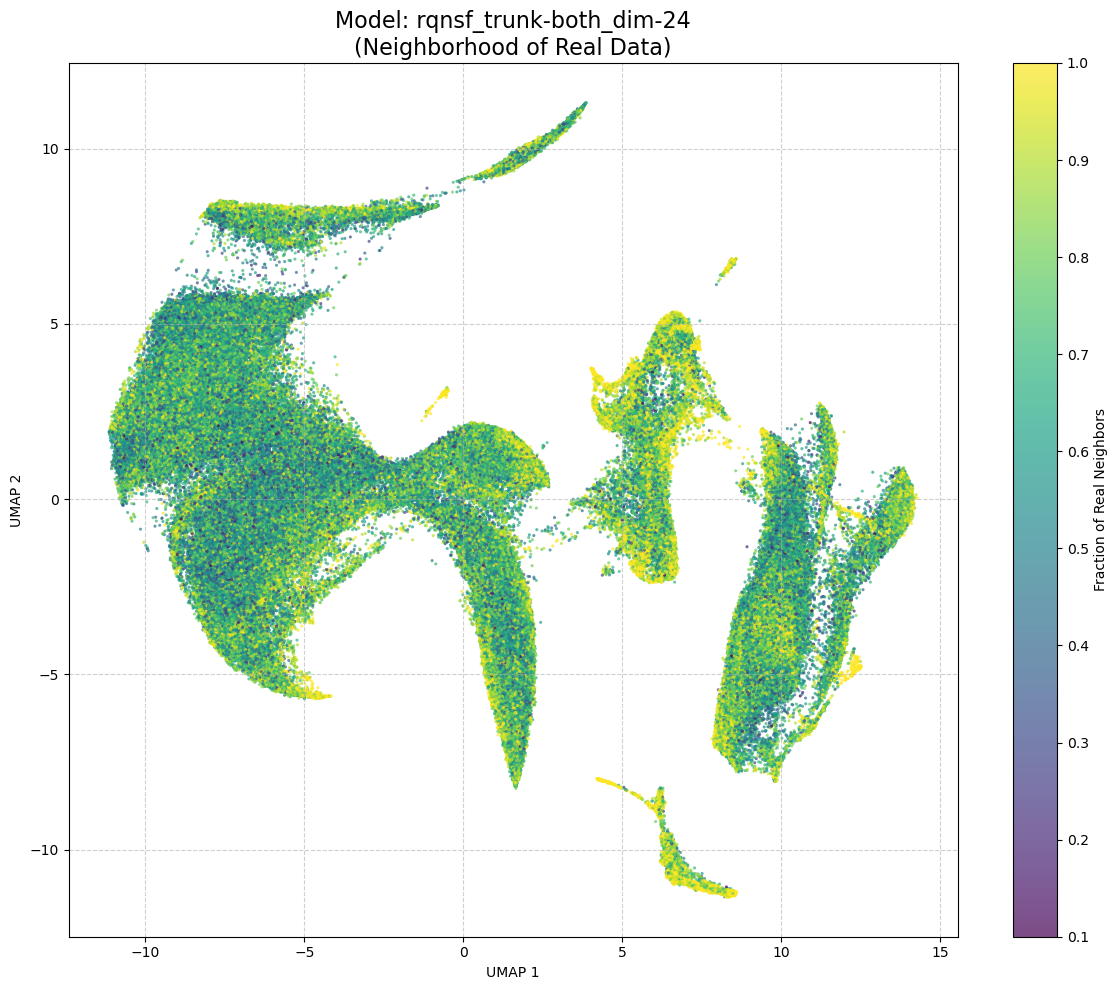

--- Starting 2D Visualization ---
Fitting UMAP model...
Creating matplotlib plot...
--- Visualization Complete ---


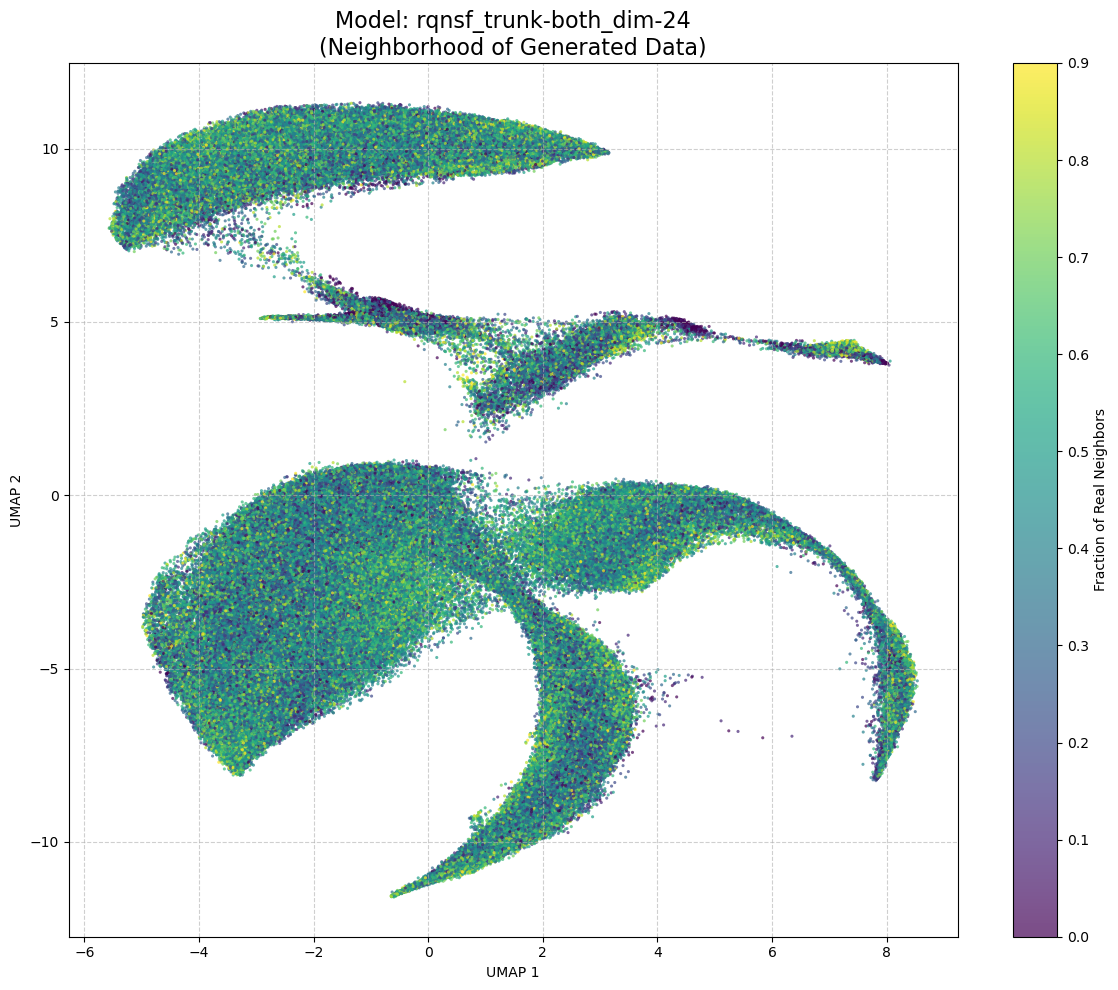

--- Starting 2D Visualization ---
Fitting UMAP model...
Creating matplotlib plot...
--- Visualization Complete ---


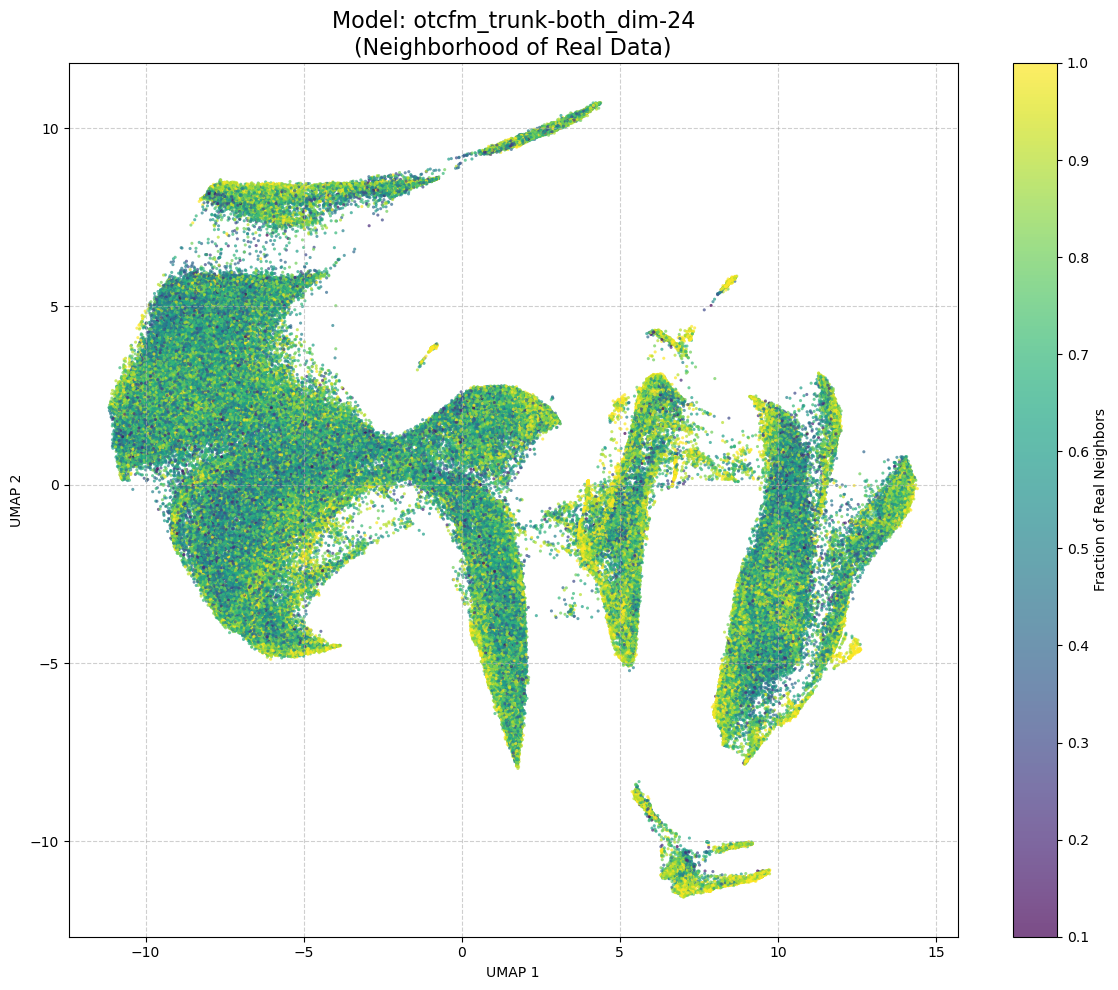

--- Starting 2D Visualization ---
Fitting UMAP model...
Creating matplotlib plot...
--- Visualization Complete ---


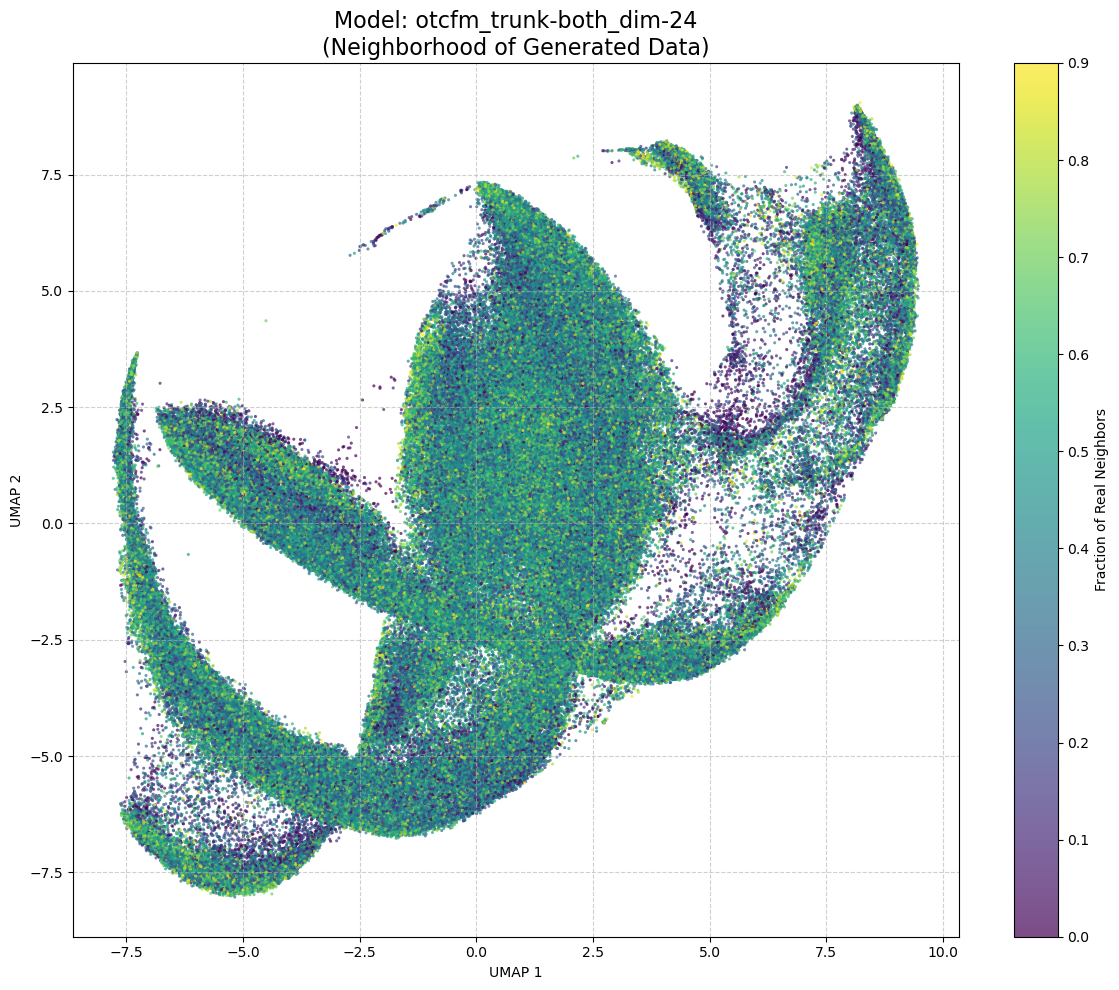

--- Starting 2D Visualization ---
Fitting UMAP model...
Creating matplotlib plot...
--- Visualization Complete ---


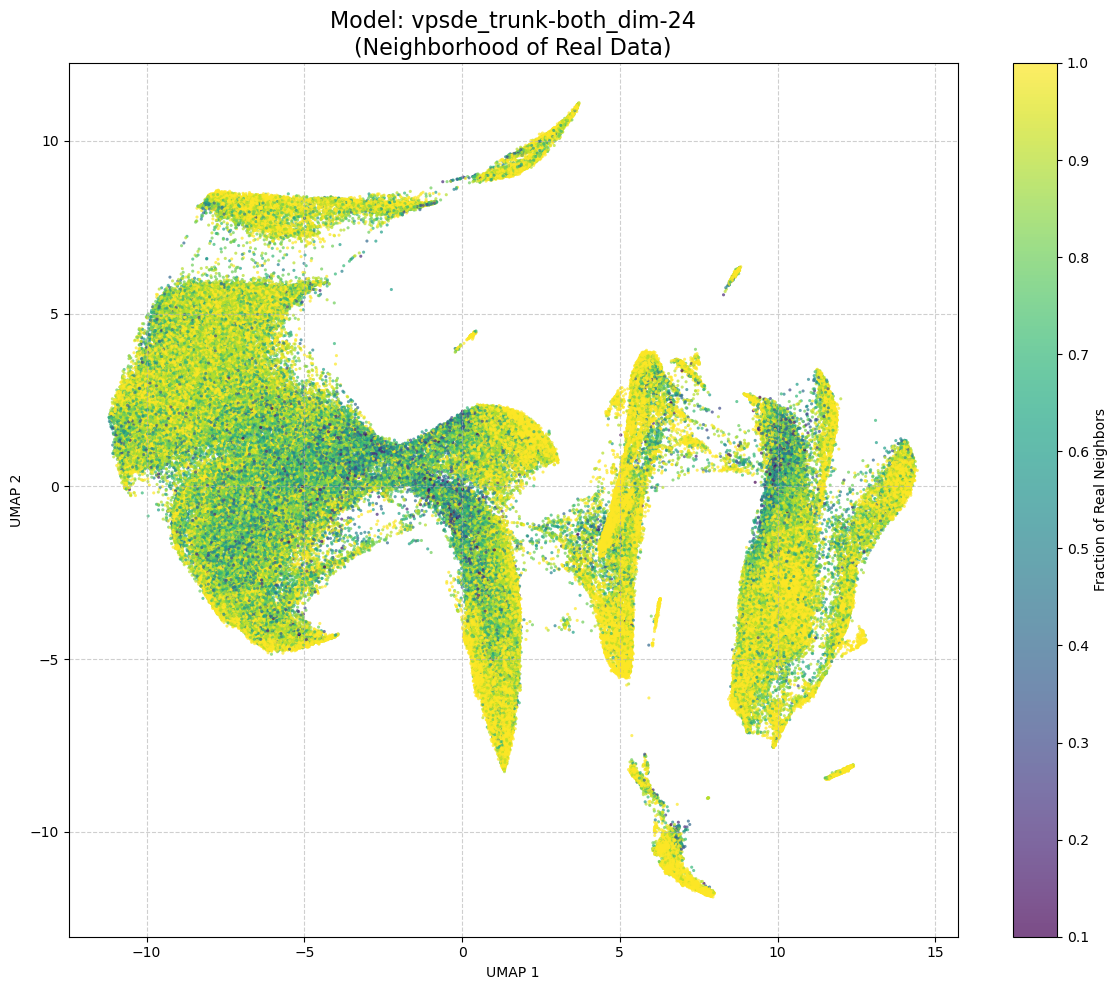

--- Starting 2D Visualization ---
Fitting UMAP model...
Creating matplotlib plot...
--- Visualization Complete ---


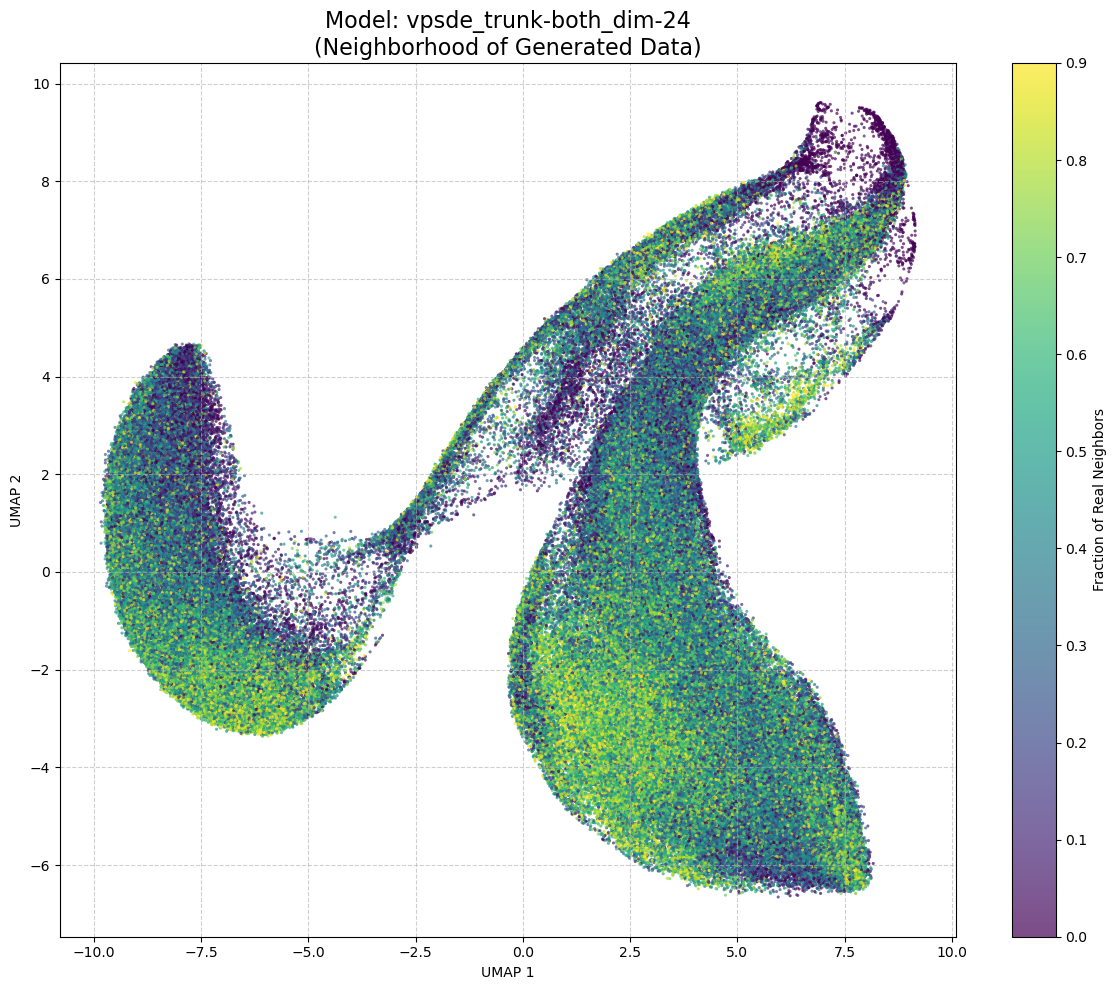

In [6]:
plot_order = [name for name in ['rqnsf_trunk-both_dim-24', 'otcfm_trunk-both_dim-24', 'vpsde_trunk-both_dim-24'] if name in evaluation_results]


if not plot_order:
    print("No models processed for plotting.")
else:
    for name in plot_order:
        results = evaluation_results[name]
        
        # --- Plot 1: Real data, colored by its neighborhood ---
        fig_real = UMAP2D(
            latent_reps=original_data,
            color_by_timepoints=results['fractions_real'],
            title=f"Model: {name}\n(Neighborhood of Real Data)"
        )
        if len(fig_real.axes) > 1 and hasattr(fig_real.axes[1], 'set_ylabel'):
             fig_real.axes[1].set_ylabel("Fraction of Real Neighbors")
        display(fig_real)

        # --- Plot 2: Generated data, colored by its neighborhood ---
        fig_fake = UMAP2D(
            latent_reps=results['generated_samples'],
            color_by_timepoints=results['fractions_fake'],
            title=f"Model: {name}\n(Neighborhood of Generated Data)"
        )
        if len(fig_fake.axes) > 1 and hasattr(fig_fake.axes[1], 'set_ylabel'):
            fig_fake.axes[1].set_ylabel("Fraction of Real Neighbors")
        display(fig_fake)